In [1]:
from pandas_datareader.data import DataReader
import requests_cache
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas_ta as pta

### Scrapping & Preparing Data from Web

In [2]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_adj_close(tickers, start_date, end_date):
    returns_df = pd.DataFrame()
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        try:
          s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
          returns_df[ticker] = s['Adj Close']
        except:
          print(ticker)
    return returns_df

In [3]:
data = pd.read_csv('C:\\Users\\Guo Xiong\\Documents\\Y3S1\\BT4222\\Project\\Apple Final.csv')
data = data.sort_values(by = 'Date')
data['Sentiment'] = data.apply(lambda x:x['probability'] if x['sentiment'] =='POSITIVE' else -x['probability'],axis=1)
data = data.drop(['probability', 'sentiment'], axis=1)
data.head(2).append(data.tail(2))

,Date,Text,neg,neu,pos,compound,0,1,2,3,4,5,6,7,8,9,Apple,Sentiment
12342,2006-12-13,Apple seems to be humming right along. Its sto...,0.000,0.899,0.101,0.6808,0.195067,0.053382,0.153705,0.0,0.0,0.000000,0.000000,0.107020,0.066871,0.422144,NaN,-0.991674
11986,2006-12-13,Apple Computer's shares are up after Morgan St...,0.083,0.792,0.125,0.2960,0.478679,0.000000,0.255793,0.0,0.0,0.000000,0.072689,0.189525,0.000000,0.000000,NaN,-0.940315
1283,2021-11-12,Disney's earnings report Wednesday told a fami...,0.000,0.898,0.102,0.5789,0.000000,0.000000,0.000000,0.0,0.0,0.109515,0.320095,0.386804,0.000000,0.180077,NaN,-0.988439
11891,2021-11-12,U.S. stock futures were little changed in earl...,0.000,0.881,0.119,0.7003,0.000000,0.000000,0.834194,0.0,0.0,0.000000,0.000000,0.154538,0.000000,0.000000,NaN,-0.999685


In [4]:
AAPL_start_date = '2016-01-01'  # Using earlier dates for calculation of SMA later
AAPL_end_date = '2020-01-28'

In [5]:
AAPL_data = DataReader('AAPL', 'yahoo', AAPL_start_date, AAPL_end_date)
AAPL_data.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
AAPL_data['Close'] = AAPL_data['Close'].shift(-1)    # for predicting tomorrow's close price
AAPL_data = AAPL_data[:-1]
AAPL_data['Movement'] = np.where(AAPL_data['Close'] > AAPL_data['Close'].shift(1),1,0)
AAPL_data['price_diff'] = AAPL_data['Close'].diff()
AAPL_data['TNX'] = DataReader('^TNX', 'yahoo', AAPL_start_date, AAPL_end_date)['Close']
#AAPL_data['Movement'] = np.where(AAPL_data['Close'] < AAPL_data['Close'].shift(-1),1,0)
#AAPL_data['price_diff'] = AAPL_data['Close'].diff().shift(-1)
AAPL_data.head(5).append(AAPL_data.tail(5))

,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX
Date,,,,,,,,,
2015-12-31,26.757500,26.205000,26.752501,26.337500,163649200.0,24.230724,0,NaN,2.269
2016-01-04,26.342501,25.500000,25.652500,25.677500,270597600.0,24.251431,0,-0.660000,2.245
2016-01-05,26.462500,25.602501,26.437500,25.174999,223164000.0,23.643721,0,-0.502501,2.248
2016-01-06,25.592501,24.967501,25.139999,24.112499,273829600.0,23.181013,0,-1.062500,2.177
2016-01-07,25.032499,24.107500,24.670000,24.240000,324377600.0,22.202667,1,0.127501,2.153
2020-01-21,79.754997,79.000000,79.297501,79.425003,110843200.0,77.984116,1,0.282501,1.769
2020-01-22,79.997498,79.327499,79.644997,79.807503,101832400.0,78.262505,1,0.382500,1.769
2020-01-23,79.889999,78.912498,79.480003,79.577499,104472000.0,78.639404,0,-0.230003,1.740
2020-01-24,80.832497,79.379997,80.062500,77.237503,146537600.0,78.412743,0,-2.339996,1.681


In [6]:
#SMA
AAPL_data['SMA20'] = AAPL_data['Close'].rolling(window=20).mean() 
AAPL_data['SMA50'] = AAPL_data['Close'].rolling(window=50).mean() 
AAPL_data['SMA100'] = AAPL_data['Close'].rolling(window=100).mean() 

#EMA
AAPL_data['EMA10'] = AAPL_data['Close'].ewm(span=10, adjust=False).mean() 
AAPL_data['EMA20'] = AAPL_data['Close'].ewm(span=20, adjust=False).mean() 
AAPL_data['EMA40'] = AAPL_data['Close'].ewm(span=40, adjust=False).mean() 

#MACD
exp1 = AAPL_data['Close'].ewm(span=12, adjust=False).mean()
exp2 = AAPL_data['Close'].ewm(span=26, adjust=False).mean()
AAPL_data['MACD'] = exp1-exp2
AAPL_data['Signal'] = AAPL_data['MACD'].ewm(span=9, adjust=False).mean()

#RSI 
AAPL_data['RSI'] = pta.rsi(AAPL_data['Close'], length = 14)

In [7]:
AAPL_data

,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,
2015-12-31,26.757500,26.205000,26.752501,26.337500,163649200.0,24.230724,0,NaN,2.269,NaN,NaN,NaN,26.337500,26.337500,26.337500,0.000000,0.000000,NaN
2016-01-04,26.342501,25.500000,25.652500,25.677500,270597600.0,24.251431,0,-0.660000,2.245,NaN,NaN,NaN,26.217500,26.274642,26.305305,-0.052650,-0.010530,NaN
2016-01-05,26.462500,25.602501,26.437500,25.174999,223164000.0,23.643721,0,-0.502501,2.248,NaN,NaN,NaN,26.027954,26.169915,26.250168,-0.133385,-0.035101,NaN
2016-01-06,25.592501,24.967501,25.139999,24.112499,273829600.0,23.181013,0,-1.062500,2.177,NaN,NaN,NaN,25.679690,25.973970,26.145891,-0.279877,-0.084056,NaN
2016-01-07,25.032499,24.107500,24.670000,24.240000,324377600.0,22.202667,1,0.127501,2.153,NaN,NaN,NaN,25.417928,25.808830,26.052921,-0.381289,-0.143503,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21,79.754997,79.000000,79.297501,79.425003,110843200.0,77.984116,1,0.282501,1.769,75.768624,70.49335,63.937575,78.035872,75.956519,72.545307,2.777624,2.692877,75.439651
2020-01-22,79.997498,79.327499,79.644997,79.807503,101832400.0,78.262505,1,0.382500,1.769,76.209000,70.78880,64.213125,78.357987,76.323279,72.899560,2.747123,2.703726,76.402492
2020-01-23,79.889999,78.912498,79.480003,79.577499,104472000.0,78.639404,0,-0.230003,1.740,76.634500,71.06935,64.487050,78.579716,76.633205,73.225314,2.673572,2.697695,74.510900


In [8]:
AAPL_data = AAPL_data.reset_index()
AAPL_data['Date'] = AAPL_data['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S")[:10]) #transform from datetime64 to date object
AAPL_data = AAPL_data.iloc[99:]     # dropping first 99 columns for NA SMA100
AAPL_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
99,2016-05-24,24.522499,24.209999,24.305000,24.905001,140560800.0,22.796698,1,0.430000,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.329950,-0.610653,57.545486
100,2016-05-25,24.934999,24.527500,24.667500,25.102501,152675200.0,23.197214,1,0.197500,1.870,23.600000,25.51675,25.023475,24.184353,24.195394,24.651078,-0.213873,-0.531297,59.581933
101,2016-05-26,25.182501,24.660000,24.920000,25.087500,225324800.0,23.381176,0,-0.015001,1.823,23.682625,25.48950,25.017575,24.348561,24.280356,24.672367,-0.121690,-0.449376,59.349065
102,2016-05-27,25.117500,24.812500,24.860001,24.965000,145364800.0,23.367201,0,-0.122499,1.851,23.760375,25.45920,25.015475,24.460641,24.345560,24.686642,-0.057851,-0.371071,57.376995
103,2016-05-31,25.100000,24.705000,24.900000,24.615000,169228800.0,23.253098,0,-0.350000,1.834,23.801375,25.42195,25.020500,24.488706,24.371221,24.683147,-0.035096,-0.303876,52.054830


In [9]:
AAPL_merged = pd.merge(data, AAPL_data, left_on = 'Date', right_on = 'Date', how = 'inner')
AAPL_merged

,Date,Text,neg,neu,pos,compound,0,1,2,3,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
0,2016-05-24,By Mia Shanley and Sven Nordenstam\nSTOCKHOLM ...,0.038,0.869,0.093,0.9819,0.076062,0.116122,0.129294,0.110990,...,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.32995,-0.610653,57.545486
1,2016-05-24,Short term Elliottwave structure suggests wave...,0.013,0.935,0.052,0.6240,0.056862,0.000000,0.535942,0.000000,...,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.32995,-0.610653,57.545486
2,2016-05-24,By Yimou Lee and Anne Marie Roantree HONG KONG...,0.072,0.823,0.105,0.9485,0.039210,0.078065,0.087940,0.073199,...,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.32995,-0.610653,57.545486
3,2016-05-24,Currencies\nEUR USD remains trading around t...,0.031,0.891,0.079,0.9481,0.054565,0.019399,0.633322,0.040828,...,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.32995,-0.610653,57.545486
4,2016-05-24,By Joseph Menn SAN FRANCISCO Reuters Apple...,0.042,0.831,0.127,0.9891,0.029072,0.058493,0.140736,0.036792,...,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.32995,-0.610653,57.545486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27421,2020-01-27,"InvestorPlace - Stock Market News, Stock Advic...",0.012,0.889,0.099,0.9954,0.187145,0.000000,0.303224,0.033892,...,1.605,77.221125,71.57040,65.016425,78.533282,76.950923,73.713785,2.33051,2.576437,65.923659
27422,2020-01-27,"InvestorPlace - Stock Market News, Stock Advic...",0.040,0.842,0.118,0.9954,0.095194,0.155242,0.172437,0.116452,...,1.605,77.221125,71.57040,65.016425,78.533282,76.950923,73.713785,2.33051,2.576437,65.923659
27423,2020-01-27,Apple s NASDAQ AAPL non iPhone segments ...,0.021,0.864,0.115,0.9974,0.141637,0.000000,0.110833,0.055010,...,1.605,77.221125,71.57040,65.016425,78.533282,76.950923,73.713785,2.33051,2.576437,65.923659
27424,2020-01-27,Cirrus Logic Inc NASDAQ CRUS is slated t...,0.027,0.833,0.140,0.9951,0.528057,0.031182,0.071512,0.031207,...,1.605,77.221125,71.57040,65.016425,78.533282,76.950923,73.713785,2.33051,2.576437,65.923659


In [10]:
AAPL_merged.columns

Index(['Date', 'Text', 'neg', 'neu', 'pos', 'compound', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', 'Apple', 'Sentiment', 'High', 'Low',
       'Open', 'Close', 'Volume', 'Adj Close', 'Movement', 'price_diff', 'TNX',
       'SMA20', 'SMA50', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal',
       'RSI'],
      dtype='object')

In [11]:
test  = AAPL_merged.copy()
test = test.groupby('Date').mean()
test['Movement'].unique()

array([1, 0])

In [12]:
test.isnull().sum()

neg            0
neu            0
pos            0
compound       0
0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
Apple         91
Sentiment      0
High           0
Low            0
Open           0
Close          0
Volume         0
Adj Close      0
Movement       0
price_diff     0
TNX            8
SMA20          0
SMA50          0
SMA100         0
EMA10          0
EMA20          0
EMA40          0
MACD           0
Signal         0
RSI            0
dtype: int64

In [13]:
test[test.isnull().any(axis=1)].iloc[:,5:]

,1,2,3,4,5,6,7,8,9,Apple,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,0.056310,0.290738,0.060350,0.090439,0.037396,0.098785,0.051856,0.110391,0.133869,NaN,...,1.859,23.530250,25.54455,25.035825,23.980320,24.099909,24.627928,-0.329950,-0.610653,57.545486
2016-05-25,0.073862,0.241838,0.089889,0.127670,0.014393,0.112304,0.049886,0.131496,0.096850,NaN,...,1.870,23.600000,25.51675,25.023475,24.184353,24.195394,24.651078,-0.213873,-0.531297,59.581933
2016-05-26,0.051327,0.347215,0.073115,0.084635,0.020142,0.109759,0.069692,0.058312,0.079013,NaN,...,1.823,23.682625,25.48950,25.017575,24.348561,24.280356,24.672367,-0.121690,-0.449376,59.349065
2016-05-27,0.029290,0.429112,0.067023,0.077377,0.018333,0.052417,0.050241,0.053262,0.116871,NaN,...,1.851,23.760375,25.45920,25.015475,24.460641,24.345560,24.686642,-0.057851,-0.371071,57.376995
2016-05-31,0.088062,0.259721,0.062852,0.083531,0.030376,0.136068,0.073446,0.078662,0.093824,NaN,...,1.834,23.801375,25.42195,25.020500,24.488706,24.371221,24.683147,-0.035096,-0.303876,52.054830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-23,0.081161,0.326336,0.074382,0.081465,0.011339,0.117543,0.098203,0.073385,0.061554,71.160714,...,NaN,49.338000,52.94180,52.371225,46.089627,48.429768,50.704049,-2.717779,-2.101082,29.564598
2018-12-24,0.097540,0.252090,0.053241,0.053205,0.037408,0.065920,0.097940,0.025769,0.098670,45.561374,...,NaN,42.053126,47.50945,51.159525,39.922096,41.818786,44.824131,-2.522591,-2.375252,36.449702
2019-07-03,0.085638,0.219067,0.064106,0.071954,0.020198,0.179318,0.049335,0.105952,0.126928,80.666667,...,NaN,49.395000,48.47590,47.515475,50.160642,49.376684,48.680599,0.887751,0.691010,65.861680


In [14]:
test = test[-test.isnull().any(axis=1)]     # removing the NA TNX rows
test.head(2).append(test.tail(2))

,neg,neu,pos,compound,0,1,2,3,4,5,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-03,0.040000,0.860176,0.099824,0.549453,0.128507,0.088146,0.255192,0.063571,0.065523,0.006645,...,1.622,27.892000,27.18995,25.707700,28.188124,27.936491,27.384369,0.380240,0.433338,57.582577
2016-10-04,0.028944,0.851111,0.120000,0.739394,0.137688,0.070171,0.160794,0.045016,0.088572,0.010021,...,1.683,27.950625,27.27185,25.764025,28.201647,27.967540,27.427205,0.361281,0.418927,57.739215
2020-01-24,0.037326,0.856767,0.105814,0.610588,0.150024,0.039599,0.313346,0.060255,0.059873,0.020121,...,1.681,76.872500,71.30430,64.745175,78.335678,76.690757,73.421030,2.398812,2.637919,58.611853
2020-01-27,0.044162,0.856081,0.099676,0.582181,0.208205,0.052096,0.281111,0.066317,0.066963,0.039344,...,1.605,77.221125,71.57040,65.016425,78.533282,76.950923,73.713785,2.330510,2.576437,65.923659


In [15]:
test['compound_score_mod'] =  test['compound']*test['SMA20']
test.head(15)

,neg,neu,pos,compound,0,1,2,3,4,5,...,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI,compound_score_mod
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-03,0.040000,0.860176,0.099824,0.549453,0.128507,0.088146,0.255192,0.063571,0.065523,0.006645,...,27.892000,27.18995,25.707700,28.188124,27.936491,27.384369,0.380240,0.433338,57.582577,15.325341
2016-10-04,0.028944,0.851111,0.120000,0.739394,0.137688,0.070171,0.160794,0.045016,0.088572,0.010021,...,27.950625,27.27185,25.764025,28.201647,27.967540,27.427205,0.361281,0.418927,57.739215,20.666537
2016-10-05,0.045000,0.887600,0.067400,0.372680,0.066320,0.094659,0.201083,0.117801,0.129277,0.034417,...,28.055250,27.32655,25.814050,28.250893,28.015631,27.478195,0.359063,0.406954,60.385716,10.455631
2016-10-06,0.039000,0.887545,0.073455,0.583464,0.075427,0.101614,0.202104,0.091816,0.134738,0.023588,...,28.191875,27.37515,25.865475,28.298912,28.063190,27.528770,0.356623,0.396888,60.919113,16.448934
2016-10-07,0.034000,0.885538,0.080615,0.507462,0.049836,0.069566,0.311838,0.049135,0.097964,0.014587,...,28.324500,27.43435,25.919200,28.428656,28.153601,27.601148,0.390334,0.395577,66.590209,14.373594
2016-10-11,0.065105,0.834132,0.100763,0.420826,0.084350,0.055471,0.223280,0.063317,0.138940,0.026668,...,28.498500,27.54990,26.029750,28.689596,28.345510,27.754114,0.454382,0.410811,69.835458,11.992919
2016-10-12,0.041545,0.835000,0.123591,0.703568,0.110000,0.047919,0.209215,0.070938,0.084662,0.019887,...,28.516125,27.60585,26.081125,28.790579,28.431176,27.826840,0.471091,0.422867,67.827632,20.063038
2016-10-13,0.045667,0.849333,0.104833,0.342017,0.180551,0.028206,0.186596,0.080460,0.063287,0.019619,...,28.550000,27.66465,26.130450,28.902746,28.524159,27.903945,0.491777,0.436649,69.530999,9.764576
2016-10-14,0.041000,0.822750,0.136000,0.983600,0.211940,0.129459,0.146657,0.086080,0.048894,0.016779,...,28.599625,27.71500,26.175275,28.990883,28.606382,27.976314,0.500784,0.449476,69.046492,28.130591


<AxesSubplot:xlabel='Date'>

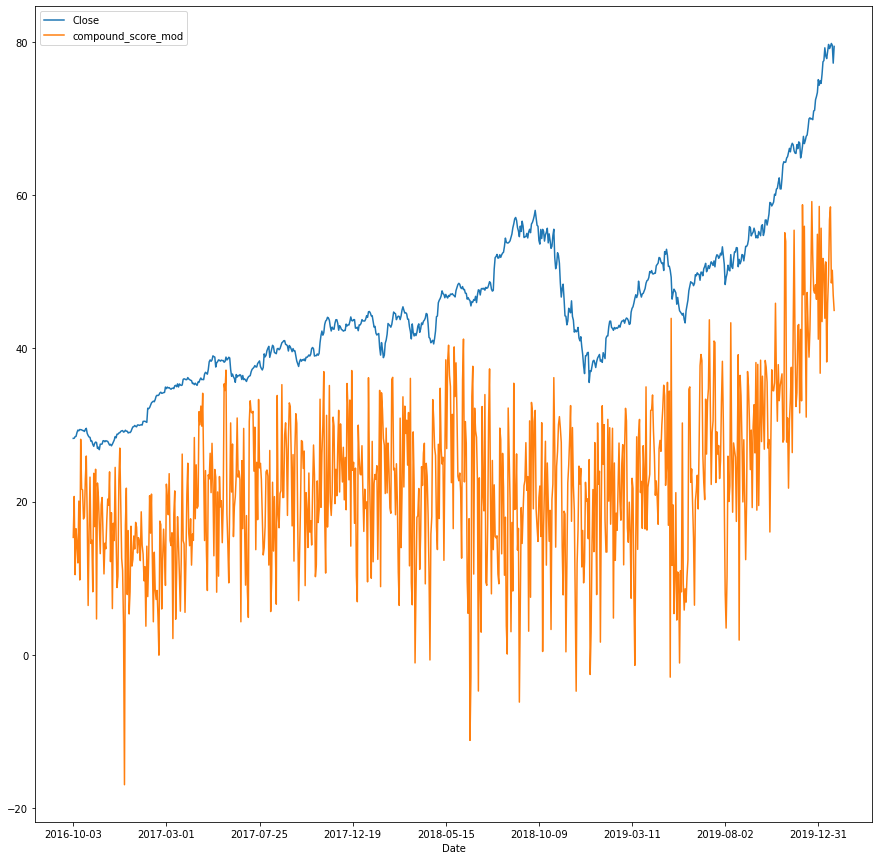

In [16]:
test[['Close', 'compound_score_mod']].plot(figsize = (15,15))

In [17]:
test1 = test.copy()

<AxesSubplot:xlabel='Date'>

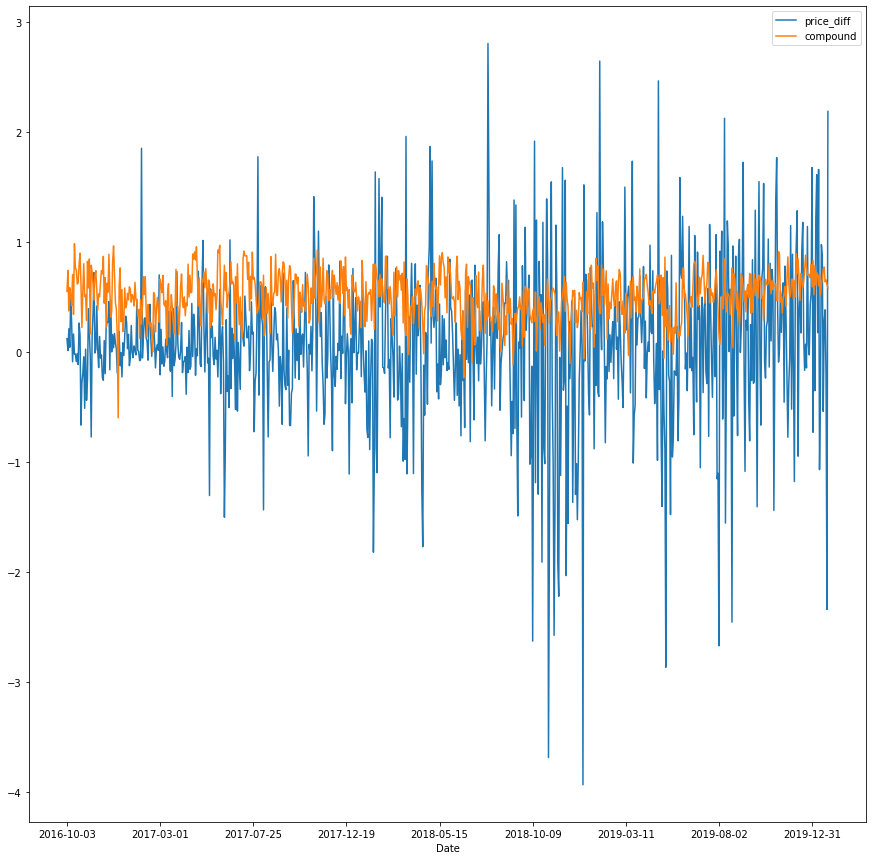

In [18]:
test1[['price_diff', 'compound']].plot(figsize = (15,15))

In [19]:
test1['same_sign'] = test1['price_diff']*test1['compound'] > 0 
print(test1['same_sign'].sum())
print(len(test1))

450
818


### Linear Regression

In [20]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from random import seed

In [21]:
seed(4222)
xvar, yvar = test1[['SMA20', 'SMA50', 'SMA100']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

In [22]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

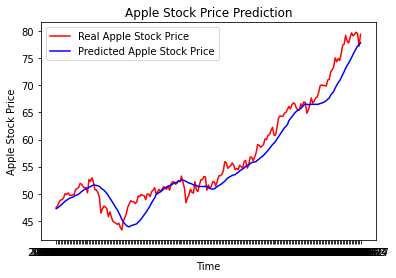

Mean squared error: 5.670
Coefficient of determination: 0.938
Adjusted R Squared: 0.937


In [23]:
pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

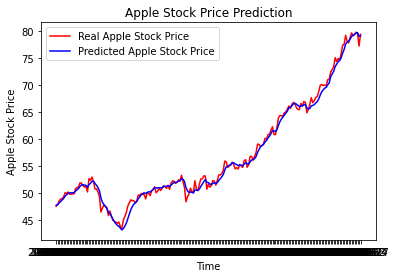

Mean squared error: 0.612
Coefficient of determination: 0.993
Adjusted R Squared: 0.993


In [24]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

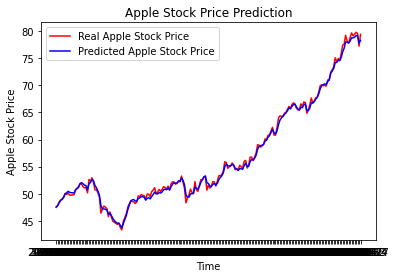

Mean squared error: 0.218
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [25]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

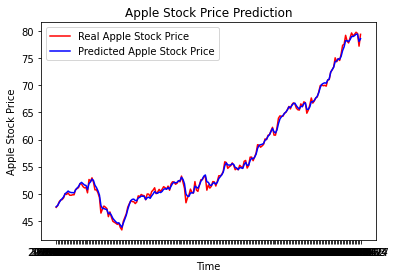

Mean squared error: 0.181
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [26]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

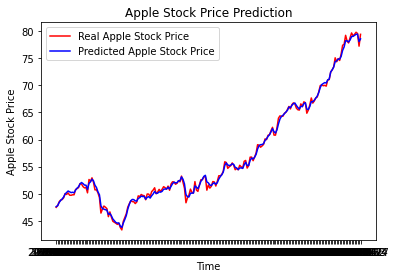

Mean squared error: 0.177
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [27]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'neg', 'neu', 'pos', 'compound']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

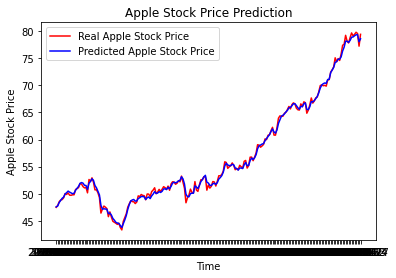

Mean squared error: 0.186
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [28]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', '0','1','2','3','4','5','6','7','8','9']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

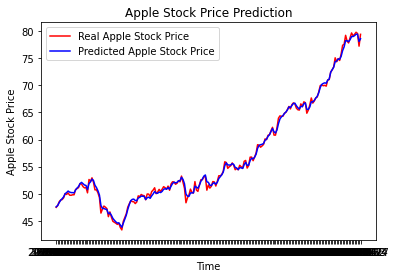

Mean squared error: 0.181
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [29]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'Apple']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

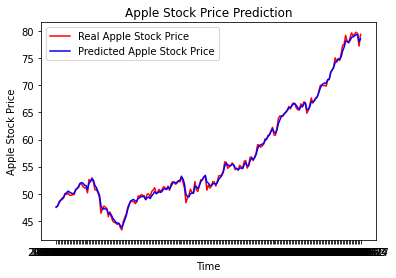

Mean squared error: 0.187
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [30]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', '0','1','2','3','4','5','6','7','8','9', 'Apple']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

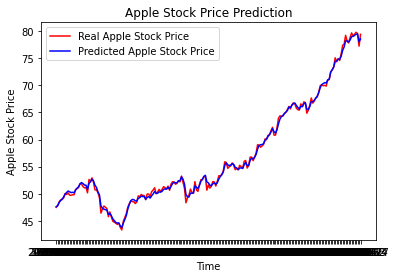

Mean squared error: 0.178
Coefficient of determination: 0.998
Adjusted R Squared: 0.998


In [109]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'neg', 'neu', 'pos', 'compound', 'Apple']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

In [32]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs

In [33]:
test.columns

Index(['neg', 'neu', 'pos', 'compound', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'Apple', 'Sentiment', 'High', 'Low', 'Open', 'Close',
       'Volume', 'Adj Close', 'Movement', 'price_diff', 'TNX', 'SMA20',
       'SMA50', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI',
       'compound_score_mod'],
      dtype='object')

In [34]:
test2 = test.drop('Close', inplace=False, axis=1)    # inplace=False means the operation would not work on the original object. axis=1 means we are dropping the column, not the row.
test2.drop('Adj Close', inplace=True, axis=1)
test2.drop('price_diff', inplace=True, axis=1)
test2.drop('Movement', inplace=True, axis=1)
test2.drop('High', inplace=True, axis=1)
test2.drop('Low', inplace=True, axis=1)
test2.columns

Index(['neg', 'neu', 'pos', 'compound', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'Apple', 'Sentiment', 'Open', 'Volume', 'TNX', 'SMA20',
       'SMA50', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI',
       'compound_score_mod'],
      dtype='object')

In [35]:
classifier = linear_model.LinearRegression()
xvar, yvar = test2, test1['Close']
x_train, x_test, y_train, y_test = train_test_split(xvar, yvar, test_size=0.25, random_state=0)

# Build step forward feature selection
forward_selection = sfs(classifier, n_features_to_select = 10, direction='forward', scoring='neg_mean_squared_error', cv=3)

# Perform SFFS
forward_selection = forward_selection.fit(x_train, y_train)

test2.columns[forward_selection.support_]

Index(['9', 'Open', 'TNX', 'SMA20', 'EMA10', 'EMA20', 'EMA40', 'MACD',
       'Signal', 'RSI'],
      dtype='object')

In [36]:
classifier = linear_model.LinearRegression()
xvar, yvar = test2, test1['Close']
x_train, x_test, y_train, y_test = train_test_split(xvar, yvar, test_size=0.25, random_state=0)

# Build step forward feature selection
backward_selection = sfs(classifier, n_features_to_select = 10, direction='backward', scoring='neg_mean_squared_error', cv=3)

# Perform SFFS
backward_selection = backward_selection.fit(x_train, y_train)

test2.columns[backward_selection.support_]

Index(['9', 'Open', 'TNX', 'SMA20', 'EMA10', 'EMA20', 'EMA40', 'MACD',
       'Signal', 'RSI'],
      dtype='object')

### Neural Network (Keras Regression)

#### Using Close Price

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [38]:
xvar, yvar = test1[['SMA20', 'SMA50', 'SMA100']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

In [39]:
scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)

kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

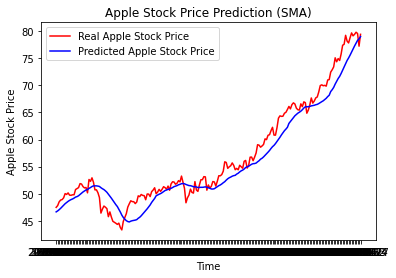

Mean squared error: 5.21
Coefficient of determination: 0.943
Adjusted R Squared: 0.942


In [40]:
pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction (SMA)')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

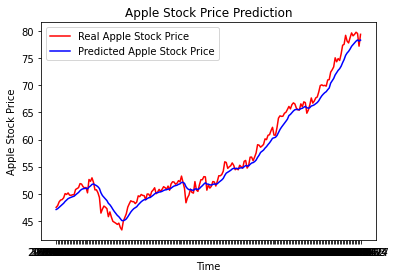

Mean squared error: 1.83
Coefficient of determination: 0.980
Adjusted R Squared: 0.980


In [41]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

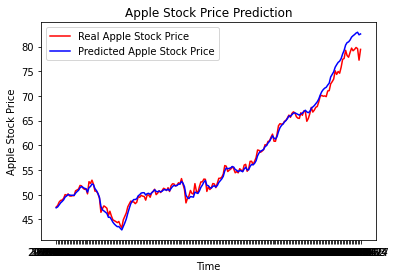

Mean squared error: 1.02
Coefficient of determination: 0.989
Adjusted R Squared: 0.988


In [93]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

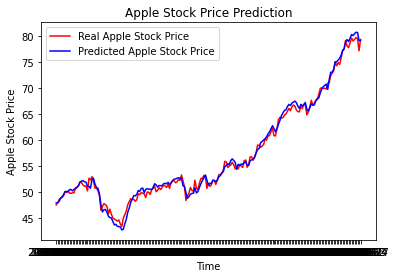

Mean squared error: 0.60
Coefficient of determination: 0.993
Adjusted R Squared: 0.993


In [91]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

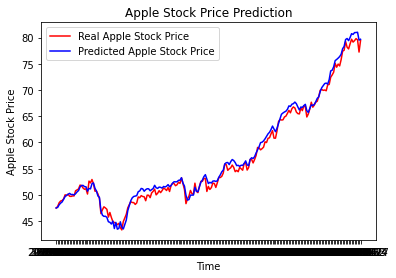

Mean squared error: 0.83
Coefficient of determination: 0.991
Adjusted R Squared: 0.990


In [99]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'neg', 'neu', 'pos', 'compound']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

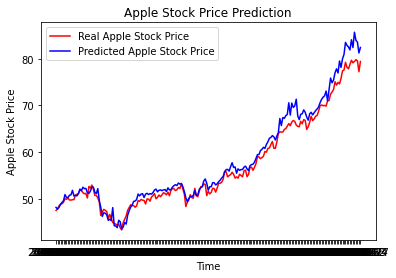

Mean squared error: 3.27
Coefficient of determination: 0.964
Adjusted R Squared: 0.961


In [45]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', '0','1','2','3','4','5','6','7','8','9']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

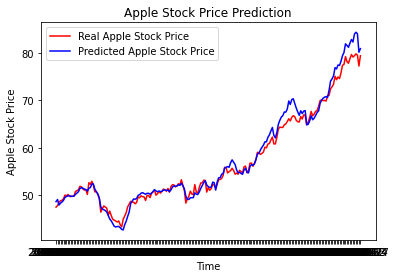

Mean squared error: 2.02
Coefficient of determination: 0.978
Adjusted R Squared: 0.977


In [46]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'Apple']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

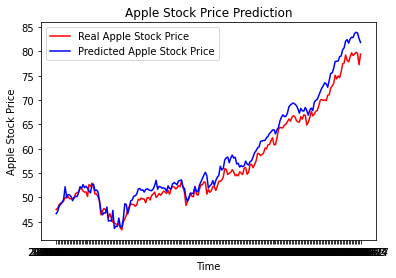

Mean squared error: 3.98
Coefficient of determination: 0.956
Adjusted R Squared: 0.952


In [47]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', '0','1','2','3','4','5','6','7','8','9', 'Apple']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

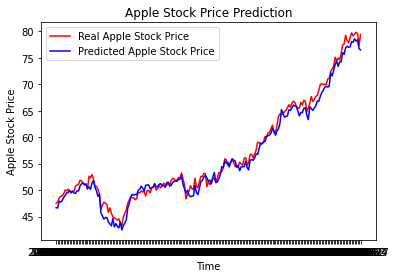

Mean squared error: 1.34
Coefficient of determination: 0.985
Adjusted R Squared: 0.984


In [108]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'neg', 'neu', 'pos', 'compound', 'Apple']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

#### Using Movement

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [50]:
xvar, yvar = test1[['SMA20', 'SMA50', 'SMA100']], test1['Movement']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtestscaled = scaler.transform(x_test)

mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=500)
mlp.fit(xscaled,y_train)
predictions = mlp.predict(xtestscaled)

[[20 67]
 [36 82]]
Accuracy: 0.4975609756097561
Precision: 0.5503355704697986
Recall: 0.6949152542372882
F1 Score: 0.6142322097378277


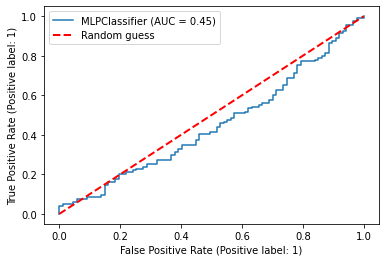

In [51]:
print(confusion_matrix(y_test,predictions))
#plot_confusion_matrix(mlp, x_test, y_test, cmap = 'Blues')
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))
print("F1 Score:", metrics.f1_score(y_test, predictions))

metrics.plot_roc_curve(mlp, x_test, y_test) 
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.legend()

[[  9  78]
 [  8 110]]
Accuracy: 0.5804878048780487
Precision: 0.5851063829787234
Recall: 0.9322033898305084
F1 Score: 0.7189542483660131


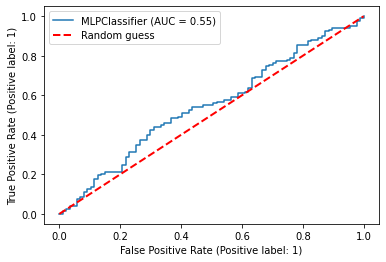

In [52]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Movement']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtestscaled = scaler.transform(x_test)

mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=500)
mlp.fit(xscaled,y_train)
predictions = mlp.predict(xtestscaled)

print(confusion_matrix(y_test,predictions))
#plot_confusion_matrix(mlp, x_test, y_test, cmap = 'Blues')
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))
print("F1 Score:", metrics.f1_score(y_test, predictions))

metrics.plot_roc_curve(mlp, x_test, y_test) 
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.legend()

[[ 32  55]
 [ 14 104]]
Accuracy: 0.6634146341463415
Precision: 0.6540880503144654
Recall: 0.8813559322033898
F1 Score: 0.7509025270758122


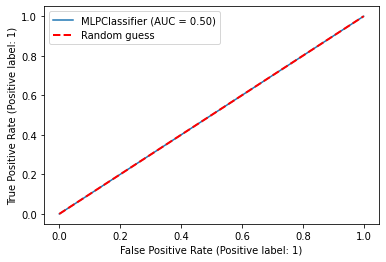

In [53]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Movement']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtestscaled = scaler.transform(x_test)

mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=500)
mlp.fit(xscaled,y_train)
predictions = mlp.predict(xtestscaled)

print(confusion_matrix(y_test,predictions))
#plot_confusion_matrix(mlp, x_test, y_test, cmap = 'Blues')
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))
print("F1 Score:", metrics.f1_score(y_test, predictions))

metrics.plot_roc_curve(mlp, x_test, y_test) 
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.legend()

[[ 36  51]
 [ 16 102]]
Accuracy: 0.6731707317073171
Precision: 0.6666666666666666
Recall: 0.864406779661017
F1 Score: 0.7527675276752768


C:\Users\Guo Xiong\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


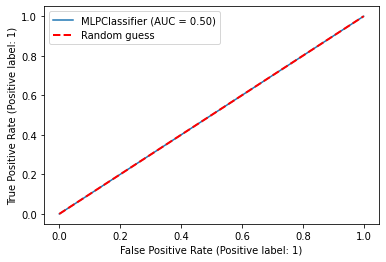

In [54]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume']], test1['Movement']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtestscaled = scaler.transform(x_test)

mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=500)
mlp.fit(xscaled,y_train)
predictions = mlp.predict(xtestscaled)

print(confusion_matrix(y_test,predictions))
#plot_confusion_matrix(mlp, x_test, y_test, cmap = 'Blues')
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))
print("F1 Score:", metrics.f1_score(y_test, predictions))

metrics.plot_roc_curve(mlp, x_test, y_test) 
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.legend()

### LSTM

#### Univariate (using only Close Price)

In [55]:
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D

In [56]:
df = DataReader("AAPL", 'yahoo', AAPL_start_date, AAPL_end_date) 
xtrain = df[:int(len(df)*0.75+1)].loc[:,'Close'].values
xtest = df[int(len(df)*0.75+1):].loc[:,'Close'].values

In [57]:
xtrain = xtrain.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,1)
xtest = scaler.transform(xtest)

In [58]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 1
x_train, y_train = create_dataset(xtrain, time_steps)

In [59]:
x_train = np.reshape(x_train, (x_train.shape[0], time_steps, 1))    # reshape it to be [samples, time steps, features]
print(x_train.shape)

(768, 1, 1)


In [60]:
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(200, return_sequences = True))
LSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(LSTM(100, return_sequences = True))
LSTMmodel.add(GlobalMaxPooling1D())
LSTMmodel.add(Dense(100, kernel_initializer='normal', activation='relu'))
LSTMmodel.add(Dense(1, kernel_initializer='normal'))
LSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = LSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

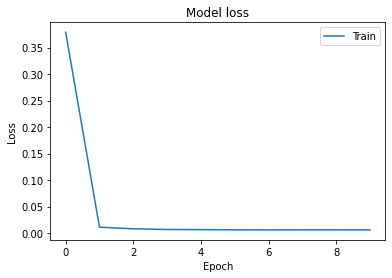

In [61]:
pyplot.plot(history.history['loss'])
#pyplot.plot(history.history['val_loss'])
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper right')
pyplot.show()

In [62]:
x_test, y_test = create_dataset(xtest, time_steps)
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], time_steps, 1))    # reshape it to be [samples, time steps, features]

In [63]:
predicted_y = LSTMmodel.predict(x_test)
predicted_y = scaler.inverse_transform(predicted_y)

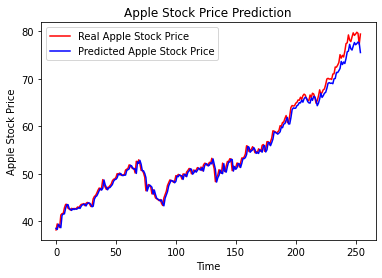

In [64]:
pyplot.plot(org_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

In [65]:
print("Mean squared error: %.2f" % metrics.mean_squared_error(org_y, predicted_y))  
print("Coefficient of determination: %.2f" % metrics.r2_score(org_y, predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(org_y, predicted_y)) * (len(org_y)-1) / (len(org_y)-x_test.shape[1]-1) ))

Mean squared error: 1.12
Coefficient of determination: 0.99
Adjusted R Squared: 0.989


#### Multivariate 

In [66]:
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

In [67]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [68]:
numLSTM = 100
numNeurons = 100

In [69]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'Close']].values

In [70]:
numfeatures = xtrain.shape[1]
xtrain

array([[27.89199982, 27.18994999, 25.7077    , 28.25      ],
       [27.95062485, 27.27185001, 25.76402502, 28.26250076],
       [28.05524988, 27.32655003, 25.81405003, 28.47249985],
       ...,
       [45.54562511, 43.07184998, 43.31672501, 47.11750031],
       [45.74025021, 43.25009995, 43.24137501, 47.18000031],
       [45.92750015, 43.42514992, 43.1607    , 47.48749924]])

In [71]:
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

In [72]:
reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,-1.757005,-1.780397,-1.838655,-1.754874,-1.748988,-1.769298,-1.831258,-1.753160
2,-1.748988,-1.769298,-1.831258,-1.753160,-1.734682,-1.761885,-1.824688,-1.724366
3,-1.734682,-1.761885,-1.824688,-1.724366,-1.715999,-1.755298,-1.817933,-1.718539
4,-1.715999,-1.755298,-1.817933,-1.718539,-1.697864,-1.747275,-1.810877,-1.650325
5,-1.697864,-1.747275,-1.810877,-1.650325,-1.674071,-1.731615,-1.796358,-1.606105
...,...,...,...,...,...,...,...,...
609,0.587623,0.298863,0.499657,0.920562,0.612424,0.322540,0.490608,0.841379
610,0.612424,0.322540,0.490608,0.841379,0.633722,0.345917,0.482251,0.774536
611,0.633722,0.345917,0.482251,0.774536,0.656968,0.371986,0.474098,0.832124
612,0.656968,0.371986,0.474098,0.832124,0.683581,0.396143,0.464202,0.840693


In [73]:
reframedxtrain.drop(reframedxtrain.columns[[4,5,6]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[4,5,6]], axis=1, inplace=True)    # dropping coloumns not used for prediction
reframedxtrain

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,-1.757005,-1.780397,-1.838655,-1.754874,-1.753160
2,-1.748988,-1.769298,-1.831258,-1.753160,-1.724366
3,-1.734682,-1.761885,-1.824688,-1.724366,-1.718539
4,-1.715999,-1.755298,-1.817933,-1.718539,-1.650325
5,-1.697864,-1.747275,-1.810877,-1.650325,-1.606105
...,...,...,...,...,...
609,0.587623,0.298863,0.499657,0.920562,0.841379
610,0.612424,0.322540,0.490608,0.841379,0.774536
611,0.633722,0.345917,0.482251,0.774536,0.832124
612,0.656968,0.371986,0.474098,0.832124,0.840693


In [74]:
x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]

In [75]:
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

In [76]:
varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

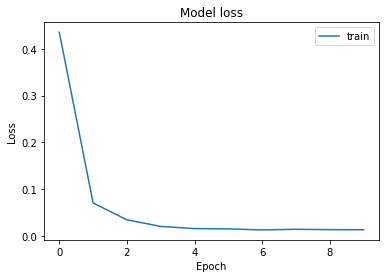

In [77]:
pyplot.plot(history.history['loss'], label='train')
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend()
pyplot.show()

In [78]:
predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

In [79]:
y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

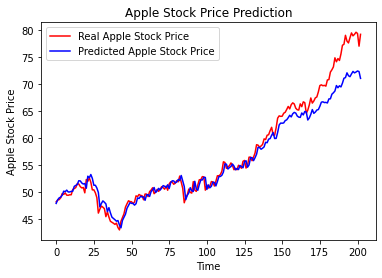

Mean squared error: 5.72
Coefficient of determination: 0.937
Adjusted R Squared: 0.936


In [80]:
pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

In [113]:
AAPL_data['price_diff'].mean()

0.05940270295014252

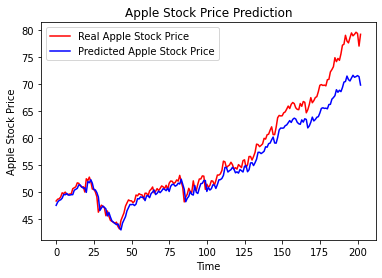

Mean squared error: 8.35
Coefficient of determination: 0.908
Adjusted R Squared: 0.906


In [81]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['EMA10', 'EMA20', 'EMA40', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['EMA10', 'EMA20', 'EMA40', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[4,5,6]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[4,5,6]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

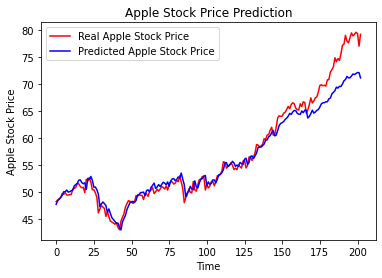

Mean squared error: 5.89
Coefficient of determination: 0.936
Adjusted R Squared: 0.933


In [94]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'Signal', 'RSI', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'Signal', 'RSI', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[7,8,9,10,11,12]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[7,8,9,10,11,12]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

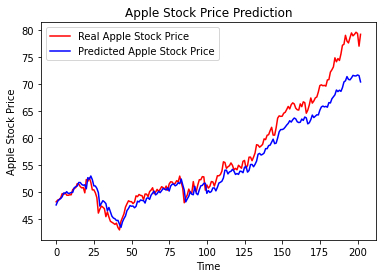

Mean squared error: 8.10
Coefficient of determination: 0.911
Adjusted R Squared: 0.909


In [95]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'TNX', 'Volume', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'TNX', 'Volume', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[6,7,8,9,10]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[6,7,8,9,10]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

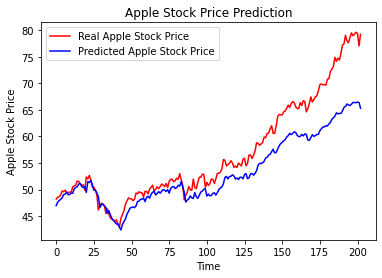

Mean squared error: 25.35
Coefficient of determination: 0.723
Adjusted R Squared: 0.710


In [98]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

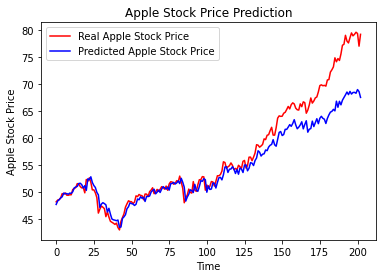

Mean squared error: 14.05
Coefficient of determination: 0.846
Adjusted R Squared: 0.840


In [101]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'neg', 'neu', 'pos', 'compound', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'neg', 'neu', 'pos', 'compound', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[8,9,10,11,12,13,14]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[8,9,10,11,12,13,14]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

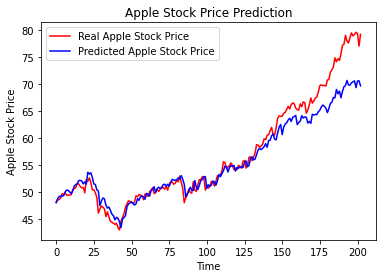

Mean squared error: 8.86
Coefficient of determination: 0.903
Adjusted R Squared: 0.896


In [103]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', '0','1','2','3','4','5','6','7','8','9', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', '0','1','2','3','4','5','6','7','8','9', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[14,15,16,17,18,19,20,21,22,23,24,25,26]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[14,15,16,17,18,19,20,21,22,23,24,25,26]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

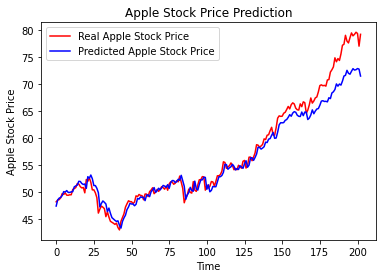

Mean squared error: 5.18
Coefficient of determination: 0.943
Adjusted R Squared: 0.942


In [104]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'Apple', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'Apple', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[5,6,7,8]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[5,6,7,8]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

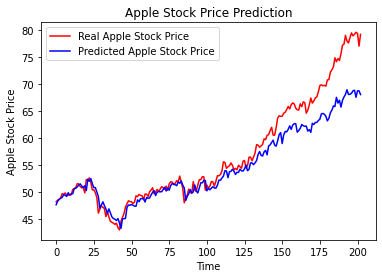

Mean squared error: 14.10
Coefficient of determination: 0.846
Adjusted R Squared: 0.833


In [105]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', '0','1','2','3','4','5','6','7','8','9', 'Apple', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', '0','1','2','3','4','5','6','7','8','9', 'Apple', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27,28]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27,28]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))

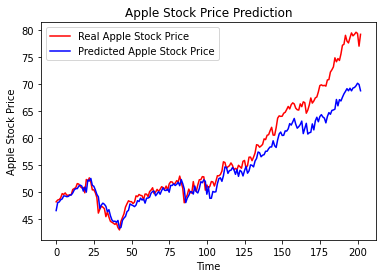

Mean squared error: 13.19
Coefficient of determination: 0.856
Adjusted R Squared: 0.849


In [106]:
xtrain = test1[:int(len(test1)*0.75+1)].loc[:, ['SMA20', 'SMA50', 'SMA100', 'neg', 'neu', 'pos', 'compound', 'Apple', 'Close']].values
xtest = test1[int(len(test1)*0.75+1):].loc[:, ['SMA20', 'SMA50', 'SMA100', 'neg', 'neu', 'pos', 'compound', 'Apple', 'Close']].values

numfeatures = xtrain.shape[1]
xtrain = xtrain.reshape(-1,numfeatures)
scaler = StandardScaler()
scaler.fit(xtrain)   # Only fit scaler to training dataset as test dataset is unseen data
xtrain = scaler.transform(xtrain)   # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
xtest = xtest.reshape(-1,numfeatures)
xtest = scaler.transform(xtest)

reframedxtrain = series_to_supervised(xtrain)
reframedxtest = series_to_supervised(xtest)
reframedxtrain.drop(reframedxtrain.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)     # dropping coloumns not used for prediction
reframedxtest.drop(reframedxtest.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)    # dropping coloumns not used for prediction

x_train, y_train = reframedxtrain.iloc[:,:-1], reframedxtrain.iloc[:,-1]
x_test, y_test = reframedxtest.iloc[:,:-1], reframedxtest.iloc[:,-1]
x_train = x_train.values.reshape(x_train.shape[0],1,x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0],1,x_test.shape[1])

varLSTMmodel = Sequential()
varLSTMmodel.add(LSTM(numLSTM, input_shape = (x_train.shape[1],x_train.shape[2])))
varLSTMmodel.add(Dropout(0.2))
#LSTMmodel.add(GlobalMaxPooling2D())
varLSTMmodel.add(Dense(numNeurons, kernel_initializer='normal', activation='relu'))
varLSTMmodel.add(Dense(1, kernel_initializer='normal'))
varLSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
history = varLSTMmodel.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

predicted_y = varLSTMmodel.predict(x_test)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
inv_predicted_y = concatenate((predicted_y, np.delete(x_test,3,1)), axis=1)     # scaler needs the same dimensions
inv_predicted_y = scaler.inverse_transform(inv_predicted_y)
inv_predicted_y = inv_predicted_y[:,0]  # predicted y after inverting the scaling is in the 1st column

y_test = y_test.values.reshape((len(y_test), 1))
inv_y = concatenate((y_test, np.delete(x_test,3,1)), axis=1)    # scaler needs the same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]  # actual y after inverting the scaling is in the 1st column

pyplot.plot(inv_y, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(inv_predicted_y, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(inv_y, inv_predicted_y))  
print("Coefficient of determination: %.3f" % metrics.r2_score(inv_y, inv_predicted_y))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(inv_y, inv_predicted_y)) * (len(inv_y)-1) / (len(inv_y)-x_test.shape[1]-1) ))